In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import networkx as nx
import torch
import torch_geometric as tg

from utils.transforms import EuclideanInformationTransform, OneHot
from  models.se3_attention_mechanisms import Se3EquivariantAttentionMechanism

import e3nn

### Let's test the SE3 equivariant version of the GAT

In [3]:
g = nx.DiGraph()

vertices = (0, 1, 2)
edges = [(0, 1),
         (1, 0),
         (1, 2),
         (2, 0),
         ]

z = [0, 1, 2,]
pos = [(0.,   0.,  0.),
       (-1., -1., -1.),
       (1.,   1.,  1.),
     ]

features = {i: {'z': z[i], 'pos': pos[i]} for i in vertices }

for v in vertices:
    g.add_node(v)

for e in edges:
    g.add_edge(*e)

nx.set_node_attributes(g, features)

graph = tg.utils.from_networkx(g)

euc_transform = EuclideanInformationTransform()
one_hot_transform = OneHot('z', 'z')
transform = tg.transforms.Compose([euc_transform, one_hot_transform])

graph = transform(graph)


In [4]:
test_dataloader = tg.data.DataLoader([graph, graph.clone()], batch_size=1)
for batch in test_dataloader:
    break

C:\Users\niksm\Documents\CodeForUni\venvs\transformer_invariants\lib\site-packages\torch_geometric\deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [5]:
feature_irreps = e3nn.o3.Irreps("10x0e + 10x1e + 10x2e")
geometric_irreps = e3nn.o3.Irreps("3x0e+3x1e+3x2e")
output_irreps = e3nn.o3.Irreps("10x0e + 10x1e + 10x2e")
internal_key_query_irreps = e3nn.o3.Irreps("5x0e + 5x1e + 5x2e")


net = Se3EquivariantAttentionMechanism(
    feature_irreps=feature_irreps,
    geometric_irreps=geometric_irreps,
    value_out_irreps=output_irreps,
    key_and_query_out_irreps=internal_key_query_irreps,
    radial_network_hidden_units=16
)


C:\Users\niksm\Documents\CodeForUni\venvs\transformer_invariants\lib\site-packages\torch\jit\_check.py:181: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn("The TorchScript type system doesn't support "


In [6]:
embed = torch.nn.Linear(batch.z.shape[1], feature_irreps.dim)
features = embed(batch.z.float())
edge_harmonics = e3nn.o3.spherical_harmonics(geometric_irreps,
                                             batch.relative_positions,
                                             normalize=False)

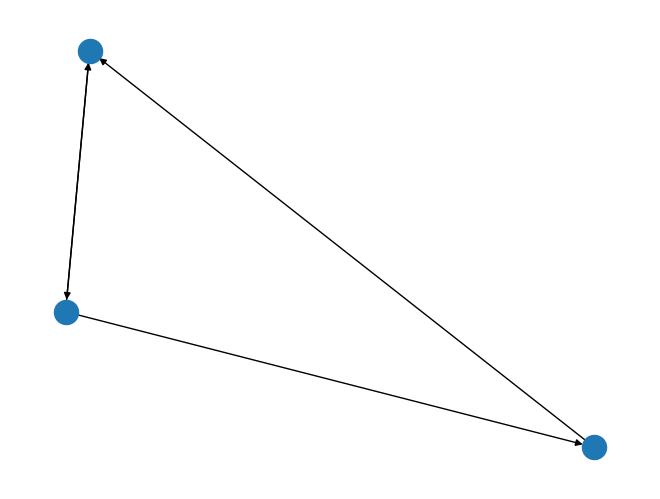

In [7]:
nx.draw(g)

In [8]:
net.forward(edge_index=batch.edge_index,
           features=features,
           edge_features=edge_harmonics,
           distances=batch.distances,
           )

tensor([[-4.6533e-01,  2.9169e-02,  1.1030e-01, -2.1910e-01,  5.6400e-01,
          3.4970e-01,  5.4592e-02, -1.5186e-01, -8.3618e-02, -1.4264e-01,
          3.2143e-01, -9.5461e-02, -1.5481e-01, -1.5274e-02, -1.7367e-02,
         -5.5257e-02,  1.3632e-03,  1.0703e-01, -2.7452e-01,  3.7344e-02,
          4.4300e-02,  3.6576e-01,  5.1716e-02,  3.9471e-02,  1.1831e-01,
         -1.8368e-01, -1.2788e-01, -1.5769e-01,  1.6532e-01, -1.7040e-02,
         -9.1793e-02, -8.5663e-02,  3.5348e-02,  2.1167e-01,  1.0714e-01,
          1.0464e-01, -7.0432e-02,  3.9482e-02, -1.8785e-01, -1.6113e-01,
         -1.1254e-01,  9.2573e-02, -7.8954e-02,  8.4302e-03,  3.6051e-02,
          5.1913e-02, -6.9304e-02,  4.2047e-02,  1.9246e-02, -2.0556e-02,
          2.8591e-02,  6.1550e-02, -3.1885e-02,  1.7676e-01, -1.0371e-01,
         -2.3507e-02,  5.5638e-02,  7.4621e-02, -3.4115e-02, -6.3893e-02,
          1.0366e-01,  1.6480e-02, -2.0684e-01, -1.8831e-01, -1.0754e-01,
         -7.3428e-02,  6.5516e-03, -4.

###